# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pandas.io.json import json_normalize
import json

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output CLEAN File (CSV)
output_data_file = "output_data/cities.csv"
# Output RAW File (CSV)
output_data_raw = "output_data/cities_raw.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    

    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
    
    
# Print the city count to confirm sufficient count
len(cities)

618

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
params = {
    "appid": weather_api_key
}

url = "http://api.openweathermap.org/data/2.5/weather?"

city_df = pd.DataFrame({"City Name" : cities})
city_df["Latitude"] = 0.0
city_df["Longitude"] = 0.0
city_df["Max_Temp"] = 0.0
city_df["Humidity"] = 0.0
city_df["Cloudiness"] = 0.0
city_df["Windspeed"] = 0.0


In [4]:
# Build partial query URL
query_url = f"{url}appid={weather_api_key}&q="

exit_value = 0

for index, row in city_df.iterrows():
    params["q"] = row["City Name"]
    response_json = requests.get(url, params=params).json()

    try:
        city_df.loc[index, "Latitude"] = response_json["coord"]["lat"]
        city_df.loc[index, "Longitude"] = response_json["coord"]["lon"]
        city_df.loc[index, "Max_Temp"] = (((response_json["main"]["temp_max"])-273.15) * 9/5 + 32)
        city_df.loc[index, "Humidity"] = response_json["main"]["humidity"]
        city_df.loc[index, "Cloudiness"] = response_json["clouds"]["all"]
        city_df.loc[index, "Windspeed"] = response_json["wind"]["speed"]
    
    except (KeyError, IndexError): 
        print("Missing field, skipping...")
    
    exit_value+=1
    if exit_value == 50:
        break
        
    

print("Done")

Missing field, skipping...
Missing field, skipping...
Missing field, skipping...
Missing field, skipping...
Done


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:

# Export the City_Data into a csv
city_df.to_csv(output_data_raw,index_label="city_id")

In [6]:
city_df.head()

,City Name,Latitude,Longitude,Max_Temp,Humidity,Cloudiness,Windspeed
0,cidreira,-30.18,-50.21,66.146,71.0,94.0,4.19
1,isangel,-19.55,169.27,77.000,65.0,75.0,2.60
2,talnakh,69.49,88.40,50.000,81.0,0.0,11.00
3,cape town,-33.93,18.42,55.994,100.0,0.0,1.00
4,yellowknife,62.46,-114.35,66.992,93.0,90.0,4.10


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [7]:
#  Get the indices of cities that have humidity over 100%.
humidity = city_df[city_df["Humidity"]>100].index
humidity

Int64Index([], dtype='int64')

In [8]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".

city_df_clean = city_df.drop(humidity, inplace = False)
city_df_clean.head()

,City Name,Latitude,Longitude,Max_Temp,Humidity,Cloudiness,Windspeed
0,cidreira,-30.18,-50.21,66.146,71.0,94.0,4.19
1,isangel,-19.55,169.27,77.000,65.0,75.0,2.60
2,talnakh,69.49,88.40,50.000,81.0,0.0,11.00
3,cape town,-33.93,18.42,55.994,100.0,0.0,1.00
4,yellowknife,62.46,-114.35,66.992,93.0,90.0,4.10


In [9]:
# Extract relevant fields from the data frame
# latitude = city_df_clean["Latitude"]
# longitude = city_df_clean["Longitude"]
# max_temp = city_df_clean["Temperature"]
# humidity = city_df_clean["Humidity"]
# cloudiness = city_df_clean["Cloudiness"]
# wind_speed = city_df_clean["Windspeed"]

# Export the CLEAN data into a csv
city_df_clean.to_csv(output_data_file,index_label="city_id")

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

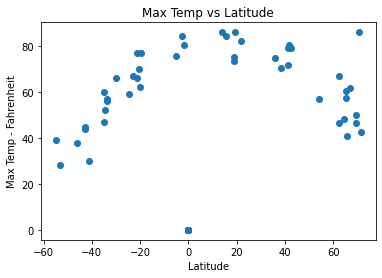

In [10]:
plt.xlabel("Latitude")
plt.ylabel("Max Temp - Fahrenheit")
plt.title("Max Temp vs Latitude")
plt.scatter(city_df_clean.Latitude, city_df_clean.Max_Temp)
plt.show()

## Latitude vs. Humidity Plot

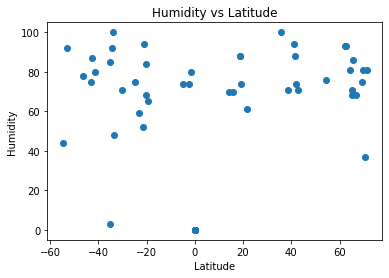

In [11]:
plt.xlabel("Latitude")
plt.ylabel("Humidity")
plt.title("Humidity vs Latitude")
plt.scatter(city_df_clean.Latitude, city_df_clean.Humidity)
plt.show()

## Latitude vs. Cloudiness Plot

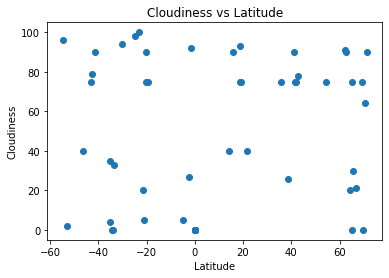

In [12]:
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
plt.title("Cloudiness vs Latitude")
plt.scatter(city_df_clean.Latitude, city_df_clean.Cloudiness)
plt.show()

## Latitude vs. Wind Speed Plot

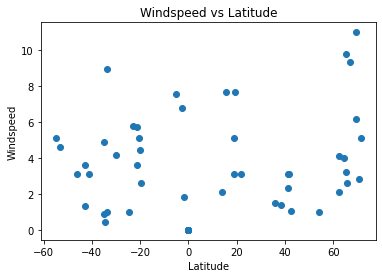

In [13]:
plt.xlabel("Latitude")
plt.ylabel("Windspeed")
plt.title("Windspeed vs Latitude")
plt.scatter(city_df_clean.Latitude, city_df_clean.Windspeed)
plt.show()

## Linear Regression

In [14]:
# Create Northern and Southern Hemisphere DataFrames
northern_hemisphere = city_df_clean[city_df_clean["Latitude"]>0]
northern_hemisphere.head()

,City Name,Latitude,Longitude,Max_Temp,Humidity,Cloudiness,Windspeed
2,talnakh,69.49,88.40,50.000,81.0,0.0,11.00
4,yellowknife,62.46,-114.35,66.992,93.0,90.0,4.10
7,nantucket,41.28,-70.10,71.600,94.0,90.0,3.10
8,chokurdakh,70.63,147.92,85.982,37.0,64.0,2.85
11,puga,21.58,-104.82,82.400,61.0,40.0,3.10


In [15]:
southern_hemisphere = city_df_clean[city_df_clean["Latitude"]<0]
southern_hemisphere.head()

,City Name,Latitude,Longitude,Max_Temp,Humidity,Cloudiness,Windspeed
0,cidreira,-30.18,-50.21,66.146,71.0,94.0,4.19
1,isangel,-19.55,169.27,77.000,65.0,75.0,2.60
3,cape town,-33.93,18.42,55.994,100.0,0.0,1.00
5,san carlos de bariloche,-41.15,-71.31,30.200,80.0,90.0,3.10
6,balclutha,-46.23,169.75,37.994,78.0,40.0,3.13


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

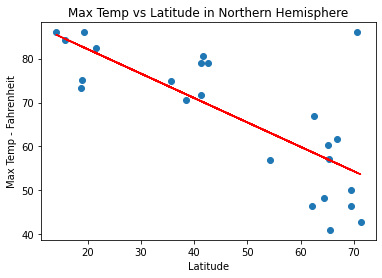

In [16]:

x_axis = northern_hemisphere["Latitude"]
y_axis = northern_hemisphere["Max_Temp"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.xlabel("Latitude")
plt.ylabel("Max Temp - Fahrenheit")
plt.title("Max Temp vs Latitude in Northern Hemisphere")
plt.scatter(x_axis,y_axis)
plt.plot(x_axis,regress_values,"r-")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

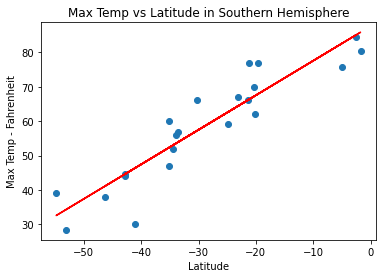

In [17]:

x_axis = southern_hemisphere["Latitude"]
y_axis = southern_hemisphere["Max_Temp"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.xlabel("Latitude")
plt.ylabel("Max Temp - Fahrenheit")
plt.title("Max Temp vs Latitude in Southern Hemisphere")
plt.scatter(x_axis,y_axis)
plt.plot(x_axis,regress_values,"r-")

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

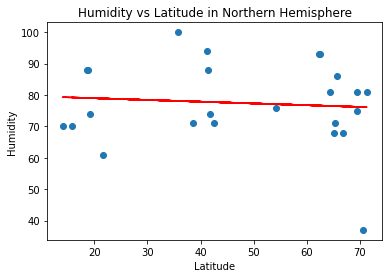

In [18]:

x_axis = northern_hemisphere["Latitude"]
y_axis = northern_hemisphere["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.xlabel("Latitude")
plt.ylabel("Humidity")
plt.title("Humidity vs Latitude in Northern Hemisphere")
plt.scatter(x_axis,y_axis)
plt.plot(x_axis,regress_values,"r-")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

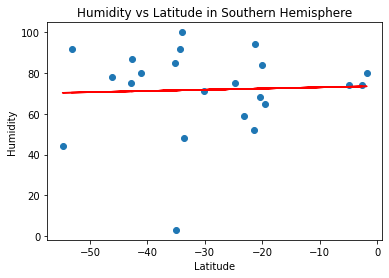

In [19]:
x_axis = southern_hemisphere["Latitude"]
y_axis = southern_hemisphere["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.xlabel("Latitude")
plt.ylabel("Humidity")
plt.title("Humidity vs Latitude in Southern Hemisphere")
plt.scatter(x_axis,y_axis)
plt.plot(x_axis,regress_values,"r-")

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

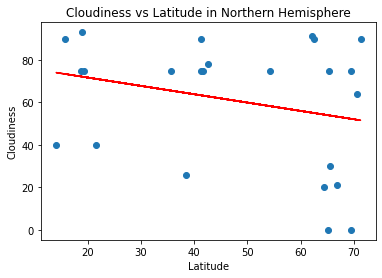

In [20]:

x_axis = northern_hemisphere["Latitude"]
y_axis = northern_hemisphere["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
plt.title("Cloudiness vs Latitude in Northern Hemisphere")
plt.scatter(x_axis,y_axis)
plt.plot(x_axis,regress_values,"r-")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

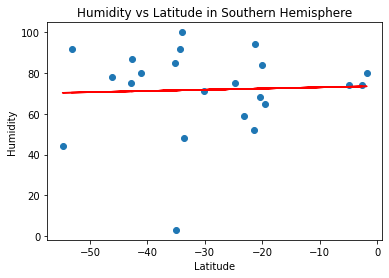

In [21]:

x_axis = southern_hemisphere["Latitude"]
y_axis = southern_hemisphere["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.xlabel("Latitude")
plt.ylabel("Humidity")
plt.title("Humidity vs Latitude in Southern Hemisphere")
plt.scatter(x_axis,y_axis)
plt.plot(x_axis,regress_values,"r-")

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

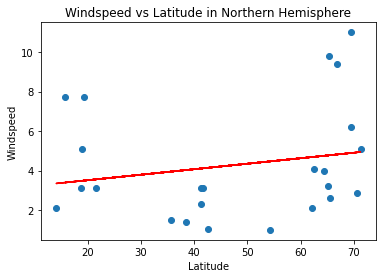

In [22]:

x_axis = northern_hemisphere["Latitude"]
y_axis = northern_hemisphere["Windspeed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.xlabel("Latitude")
plt.ylabel("Windspeed")
plt.title("Windspeed vs Latitude in Northern Hemisphere")
plt.scatter(x_axis,y_axis)
plt.plot(x_axis,regress_values,"r-")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

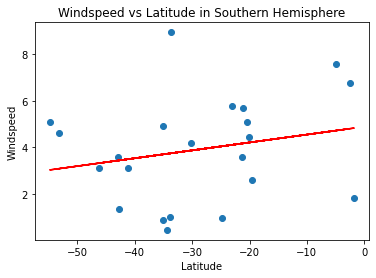

In [23]:

x_axis = southern_hemisphere["Latitude"]
y_axis = southern_hemisphere["Windspeed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.xlabel("Latitude")
plt.ylabel("Windspeed")
plt.title("Windspeed vs Latitude in Southern Hemisphere")
plt.scatter(x_axis,y_axis)
plt.plot(x_axis,regress_values,"r-")